<h1 align='center'>Neural Networks and Deep Learning</h1>
<img align='right' src='https://www.unidformazione.com/wp-content/uploads/2018/04/unipd-universita-di-padova.png' alt='Drawing' width='300'>


<h2 align='left'>Homework 3 - Deep Reinforcement Learning</h2>


<h3 align='left'>University of Padua - Physics of Data</h3>
<h4 align='left'>Dott. Alberto Testolin, Dott. Umberto Micheli</h4>

**Name** | **ID number** | **mail**@studenti.unipd.it
:-:|:-:|-:
Samuele Piccinelli | 2027650 | samuele.piccinelli

<a id='index'></a>
### Index

#### 1. [Introduction](#1)
#### 2. [Class definitions](#2)
#### 3. [Exploration strategies and profiles](#3)
#### 4. [Training functions](#4)
#### 5. [CartPole optimization](#5)
#### 6. [MountainCar](#6)
#### 7. [Conclusion](#7) 

<a id='1'></a>
[Index](#index)
### 1. Introduction

Reinforcement learning is the training of machine learning models to make a sequence of decisions. The agent learns to achieve a goal in an uncertain, potentially complex environment to maximize a given reward, thus facing a game-like situation.<br>
A common RL algorithm is Q-learning: in this framework the learning procedure is focused on finding a mapping between pairs of states-actions and their expected cumulative rewards. Deep neural networks can be exploited to learn such mapping, leading to Deep Q-learning Networks (DQNs).

In this work we will train a neural network as a DQN agent in two different settings from the OpenAI `gym`, the **CartPole** and **MountainCar** environment, exploring different hyperparameters and rewards tweaks to improve the convergence speed and the overall learning procedure.

As a main reference, we will use the article [Playing Atari with Deep Reinforcement Learning](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf) by V. Mnih *et. al* and make use of the [PyVirtualDisplay](https://github.com/ponty/PyVirtualDisplay) library.

In [1]:
# Import useful libraries and dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from copy import deepcopy
from pathlib import Path
import random
import os
import io
import glob
import pickle
import base64
from collections import deque
from datetime import datetime

import gym

# Visualization libraries
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

# Import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

In [2]:
print('Torch version:', torch.__version__)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using {device} for training/testing')

Torch version: 1.10.0
Using cuda for training/testing


In [3]:
# Set seed for reproducibility
seed = 0

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

We first define some utility functions to enable the video recordings of a gym environment and its display within a jupyter notebook.

In [4]:
def show_videos(save_dir='./video'):
    mp4list = glob.glob(f'{save_dir}/*.mp4')
    mp4list.sort()
    for mp4 in mp4list:
        print(f'\nSHOWING VIDEO {mp4}')
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt='test' autoplay 
                    loop controls style='height: 400px;'>
                    <source src='data:video/mp4;base64,{0}' type='video/mp4' />
                    </video>'''.format(encoded.decode('ascii'))))

def wrap_env(env, save_dir='./video', video_callable=None):
    env = Monitor(env, save_dir, force=True, video_callable=video_callable)
    return env

<a id='2'></a>
[Index](#index)
### 2. Class definitions

We define the `ReplayMemory` class implementing the so-called *experience replay*, a technique used both to improve the convergence properties of the algorithm and to reduce data correlation. The class makes use of Python's `deque` function to store the agent's last experiences, forming a queue of fixed length capacity. When capacity is full, the oldest replays are removed to make space for the new ones.

The `DQN` class includes the architecture of both the policy and target network: the former takes a state in input and returns the possible Q-value for each of the possible actions, while the latter is employed for a more stable learning process and to reduce possible correlations between the target function and the Q-network. The update from the policy to the target network happens only after a fixed number of steps (`target_net_update_steps` variable).

The network is composed of two fully connected layers with the input and output layer of dimension equal respectively to the state space and to the action space and one hidden layer composed of 128 neurons activated by the hyperbolic tangent function.

In [5]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, next_state, reward):
        # Add the tuple to the queue
        self.memory.append( (state, action, next_state, reward) )

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self))
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [6]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
                nn.Linear(state_space_dim, 128),
                nn.Tanh(),
                nn.Linear(128, action_space_dim)
                )

    def forward(self, x):
        return self.linear(x)
    
# Define an example network
net = DQN(state_space_dim=4, action_space_dim=2)
print(net)

DQN(
  (linear): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)


<a id='3'></a>
[Index](#index)
### 3. Exploration strategies and profiles

Starting from the estimated Q-values, the agent chooses then the action to take, according to an *exploration policy*, a component that allow the agent to trade-off between two criteria:
- **Exploration**: The agent takes action with a policy that might not return immediate advantage but explores all action space, making convergence more robust;
- **Exploitation**: The agent always chooses the action with the maximum expected return.

Two different exploration strategies are defined:
- $\mathbf{\varepsilon}$**-greedy**: The agent takes action using the greedy policy (optimal action) with a probability of $1-\varepsilon$ and a random action with a probability of $\varepsilon$;
- **Softmax**: The action is chosen according to a softmax distribution of the Q-values with temperature $\tau$. In this work, the softmax strategy is employed when not specified otherwise.

Moreover, $\tau$ is initially set to high values and decreased exponentially during training (`softmax_exploration_profile`), thus allowing the agent some time to explore the environment before settling in a learned optimal behavior. We compute the exponential decay to make the shape of the exploration profile independent on the number of iterations. Besides, a function that adds gaussian fluctuations (`add_gauss_fluctuation`) is implemented to see its effect on the learning process. Up to two fluctuations are added to the profile, with probability respectively of $0.2$ and $0.2^2=0.04$.

In [7]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    assert (epsilon < 1 or epsilon > 0), 'The epsilon value must be between 0 and 1!'
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

In [8]:
def choose_action_softmax(net, state, temperature):
    
    assert temperature > 0, 'The temperature value must be greater than or equal to 0!'
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with eps = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # Set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    # This samples a random element from 'all_possible_actions' with the probability distribution p (softmax_out)
    action = np.random.choice(all_possible_actions, p=softmax_out)
    
    return action, net_out.numpy()

In [9]:
def softmax_exploration_profile(num_iterations=1000, initial_value=5):
    if initial_value != 1:
        exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6)
        exploration_profile = np.array([initial_value * (exp_decay ** i) for i in range(num_iterations)])
    else:
        exploration_profile = np.array([np.exp(-i / num_iterations * 6) for i in range(num_iterations)])
    return exploration_profile

def gauss_fluctuation(x, mu = 0., sigma = 1., A = 1.):
    fluctuation = A * np.exp(-0.5 * (x - mu)**2/sigma**2) / (sigma * np.sqrt(2*np.pi))
    return fluctuation

def add_gauss_fluctuation(exploration_profile, probability=0.2, plot=False):
    xmin = -3; xmax = 3
    n_iter = len(exploration_profile)
    noiseless = deepcopy(exploration_profile)
    if np.random.rand() < probability:
        num = np.random.randint(0, 9)
        idx = (n_iter//10)
        gauss = gauss_fluctuation(np.linspace(xmin, xmax, 100))
        exploration_profile[num * idx : (num+1) * idx] += gauss
        if np.random.rand() < probability:
            num = np.random.randint(0, 9)
            gauss = gauss_fluctuation(np.linspace(xmin, xmax, 100))
            exploration_profile[num * idx : (num+1) * idx] += gauss
    if plot:
        plt.figure(figsize=(14,4))
        plt.subplot(1, 2, 1)
        plt.plot(noiseless, color='b'); plt.grid()
        plt.xlabel('Episode'); plt.ylabel('Exploration profile')
        plt.title('Softmax temperature')

        plt.subplot(1, 2, 2)
        plt.plot(exploration_profile, color='r'); plt.grid()
        plt.xlabel('Episode'); plt.ylabel('Exploration profile')
        plt.title('Softmax temperature and gaussian fluctuation')

        plt.tight_layout()
        plt.show()
    return exploration_profile

<a id='4'></a>
[Index](#index)
### 4. Training functions

In the `CartPole` gym environment, the agent controls a cart $C$ moving without friction in one dimension on a 2D plane, with the goal of vertically balancing the pole $P$ attached to it. At any moment the state is given by the 4-tuple $(x_C, \dot{x}_C, \theta_P, \dot{\theta}_P)$,

\begin{align}
&x_C\in[-4.8,4.8] \text{, cart position}\\
&\dot{x_C}\in[-\infty,\infty] \text{, cart velocity}\\
&\theta_P\in[-15^{\circ},15^{\circ}] \text{, pole angle wrt. the vertical}\\
&\dot{\theta}_P\in[-\infty,\infty] \text{, pole angular velocity.}
\end{align}

The agent can choose between 2 possible actions at every frame of the simulation, namely apply a fixed impulse to the cart either to the left or to the right, with the velocity depending on the pole angle. The reward is +1 for every step taken, including the terminating step: an episode ends when the pole falls (i.e. it surpasses the $\pm 12^{\circ}$ angle threshold) or when the simulation lasts more than 500 steps. 

In [10]:
env = gym.make('CartPole-v1') 
env.seed(seed)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f'State space size: {state_space_dim}')
print(f'Action space size: {action_space_dim}')

State space size: 4
Action space size: 2


In this section we define the `update_step` function, used to compute and select the proper Q-value, compute the value function of the next states using the target network and optimize the model.<br>
To facilitate learning, gradients during training are clipped to a maximum norm of 2, to lower the risk of "catastrophic forgetting". The loss function is chosen to be the [`SmoothL1Loss`](https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html) from PyTorch, which can be interpreted as a combination of L1-loss and L2-loss. In fact, it behaves as L1-loss when the absolute value of the argument is high, and like L2-loss when the absolute value of the argument is close to zero, while being differentiable everywhere. To update the parameters of the policy network, Adam optimizer was chosen.

Finally, we implement the `train_loop` and `initialize` methods, utility functions to wrap respectively the training process and the initialization of the replay memory, optimizer, loss function, target and policy network. We tweak slightly the reward during training by adding a linear penalty proportional to the distance from the center of the screen, preventing scenarios where the cart "escapes" the simulation space.

In [11]:
def update_step(policy_net, target_net, replay_mem, params, optimizer, loss_fn):
    gamma = params['gamma']
    batch_size = params['batch_size']
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states  = torch.tensor(np.array([s[0] for s in batch]), dtype=torch.float32)
    actions = torch.tensor(np.array([s[1] for s in batch]), dtype=torch.int64)
    rewards = torch.tensor(np.array([s[3] for s in batch]), dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    # The next state can be None if the game has ended
    non_final_next_states = torch.tensor(np.array([s[2] for s in batch if s[2] is not None]), dtype=torch.float32)
    non_final_mask = torch.tensor(np.array([s[2] is not None for s in batch]), dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a[Q_target(s_{t+1}, a)]
    with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

In [12]:
def train_loop(policy_net, target_net, replay_mem, exploration_profile, params, verbose=False):
    # Initialize the Gym environment
    env = gym.make('CartPole-v1') 
    env.seed(seed)

    training_score = []

    for episode_num, tau in enumerate(tqdm(exploration_profile)):
        
        # Reset the environment and get the initial state
        state = env.reset()
        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done = False # True if the game has ended

        # Run until the pole falls off
        while not done:

            # Choose the action following the policy
            action, q_values = choose_action_softmax(policy_net, state, temperature=tau)

            # Apply the action and get the next state, the reward and a 'done' flag
            next_state, reward, done, info = env.step(action)

            # We apply a (linear) penalty when the cart is far from center
            pos_weight = 1
            reward = reward - pos_weight * np.abs(state[0]) 

            # Update the final score (+1 for each step)
            score += 1

            # Apply penalty for bad state, i.e. if the pole has fallen down
            if done: 
                reward += params['bad_state_penalty']
                next_state = None

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # Update the network:
            # we enable the training only if we have enough samples in the replay
            # memory, otherwise the training will use the same samples too often
            if len(replay_mem) > params['min_samples_for_training']:
                update_step(policy_net, target_net, replay_mem, params, optimizer, loss_fn)

            # Visually render the environment (disable to speed up the training)
            env.render()
                
            # Set the current state for the next iteration
            state = next_state

        # Update the target network every target_net_update_steps episodes
        if episode_num % params['target_net_update_steps'] == 0:
            if verbose:
                print('Updating target network...')
            # Copy the weights of the policy network to the target network
            target_net.load_state_dict(policy_net.state_dict())

        # Print final score
        if verbose:
            print(f'EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}')
            
        training_score.append(score)
        
    env.close()
    
    return policy_net, training_score

In [13]:
def initialize(params, replay_memory_capacity=10000, state_space_dim=4, action_space_dim=2):
    # Initialize the replay memory
    replay_mem = ReplayMemory(replay_memory_capacity)    

    # Initialize the policy network
    policy_net = DQN(state_space_dim, action_space_dim)
    # Initialize the target network with the same weights of the policy network
    target_net = DQN(state_space_dim, action_space_dim)
    # Copy the weights of the policy network to the target network
    target_net.load_state_dict(policy_net.state_dict()) 

    # Initialize the optimizer:
    # the optimizer will update ONLY the parameters of the policy network
    optimizer = torch.optim.Adam(policy_net.parameters(), lr=params['learning_rate']) 

    # Initialize the loss function (Huber loss)
    loss_fn = nn.SmoothL1Loss()

    return replay_mem, policy_net, target_net, optimizer, loss_fn

In [14]:
def rolling_average(values, window):
    x = np.arange(window // 2, len(values) - (window - window // 2) + 1)
    y = np.convolve(values, np.ones(window), 'valid') / window
    return x, y

def plot_score(exploration_profile, score, params, gym='pole'):
    if gym == 'car':
        xmin = 0; xmax = 200
        y = xmin
    else:
        xmin = 0; xmax = 1000
        y = 500
    
    score = np.array(score)
    
    # Text box with parameters
    box = ''
    for key, value in params.items():
        if 'float' in str(type(value)):
            box += ('%s : %.3f\n' %(key, value))
        else:
            box += ('%s : %i\n' %(key, value))
    box = box[:-1]
   
    # Plot exploration profile
    fig, ax = plt.subplots(figsize=(10,6))

    color = 'tab:red'
    ax.set_ylabel('Exploration profile', size=12, c=color)
    ax.plot(exploration_profile, c=color, label='Softmax temperature')
    ax.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax.twinx()
    
    color = 'tab:blue'   
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Score', c=color, size=12, rotation=270, labelpad=15)
    ax2.hlines(y, xmin, xmax, colors='black', linestyles='dotted', alpha=.8)
    ax2.plot(score, c=color, alpha=.4, label='Raw score')
    winw = 15
    ax2.plot(*rolling_average(score, winw), '--', color=color, label=f'Rolling average ({winw})')
    ax2.tick_params(axis='y', labelcolor=color)
    
    props = dict(boxstyle='round, pad=0.3', facecolor='gray', edgecolor='black', alpha=.1)
    ax.text(0.6, 0.65, box, transform=ax.transAxes, verticalalignment='top', fontsize=12, bbox=props)
    
    ax2.legend(loc=(0.7, 0.7))
    ax.legend(loc=(0.7, 0.8))
    
    fig.tight_layout()
    plt.show()

<a id='5'></a>
[Index](#index)
### 5. CartPole optimization

Small tweaks to the training hyperparameters greatly affect the behaviour and speed of convergence in a RL algorithm. We make a small scale search (30 runs), with the goal of solving the `CartPole` environment with the lowest number of steps.<br>
We generate 20 different exploration profiles to be randomly applied during hyperparameter optimization, with a fixed initial temperature of $\tau=5$. The parameters to be optimized are:

- **Discount rate gamma**, parameter for the long term reward, taken in the $[0.9,0.99]$ interval at $0.01$ steps.
- **Batch size**, i.e. the number of samples to take from the replay memory for each update, fixed after an initial search at $128$.
- **Optimizer learning rate**, chosen in the log-uniform interval of $[10^{-2},10^{-1}]$. Due to the dynamical nature of the problem, we do not use momentum since the optimization direction may change quickly.
- **Target network update steps**, i.e. the number of episodes to wait before updating the target network, fixed at $5$.

The capacity of the replay memory is set to $10000$, while the minimum number of samples in the replay memory to enable the training process and the extra penalty factor for discouraging bad states are set to $1000$ and $0$ respectively.

To better understand the evolution of the training and the effect of the exploration profile we plot the exploration profile and the training score along each episode of the simulation on a two-axis graph. The training score is subject to fluctuations along the evolution: we take a rolling average on a window of 15 time steps, taking as relative time
step the central one.

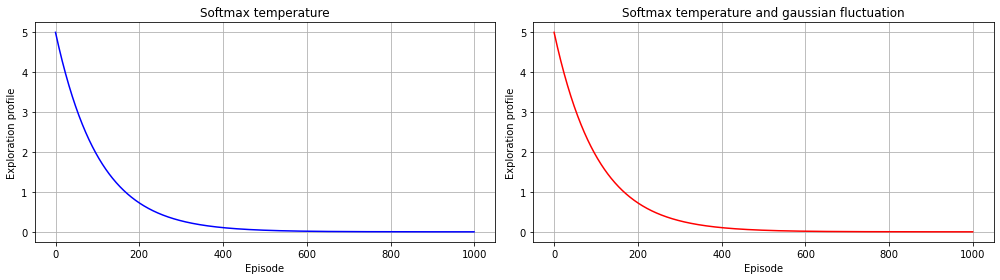

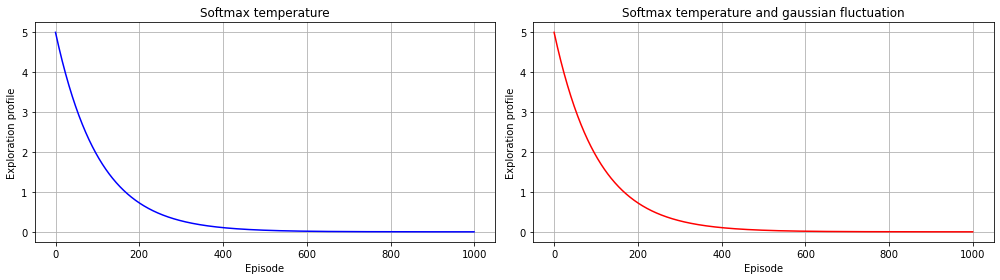

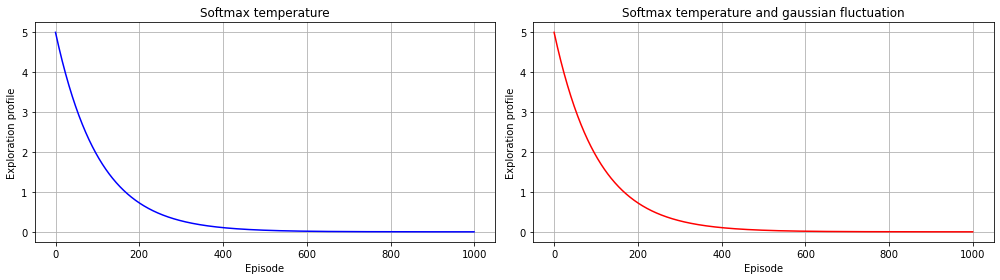

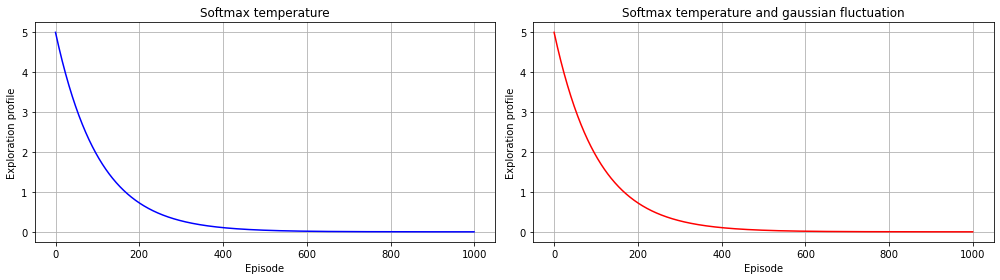

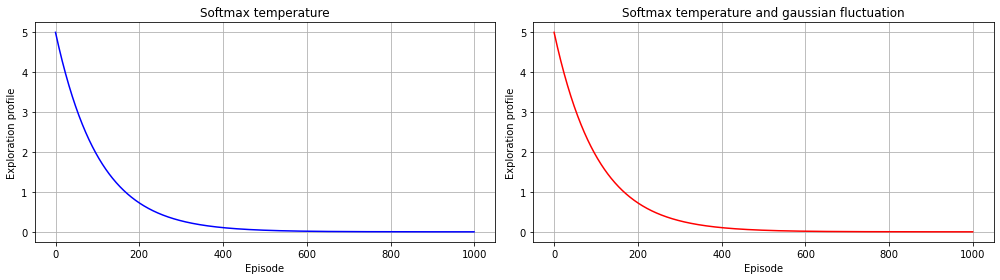

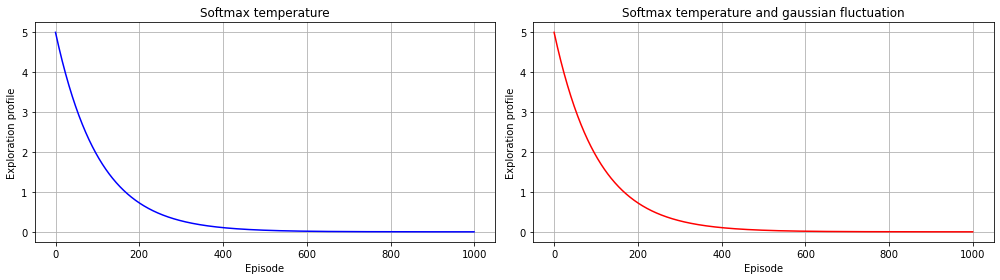

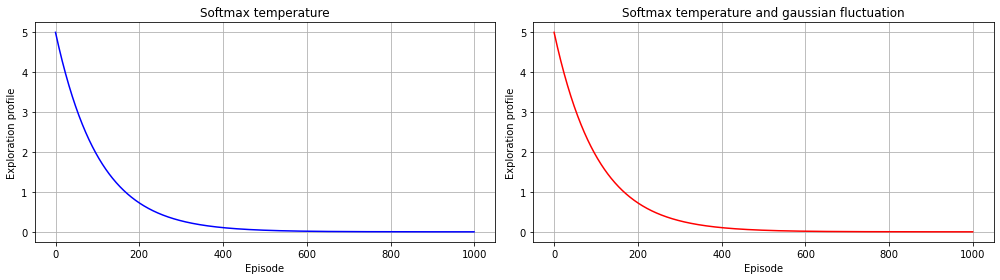

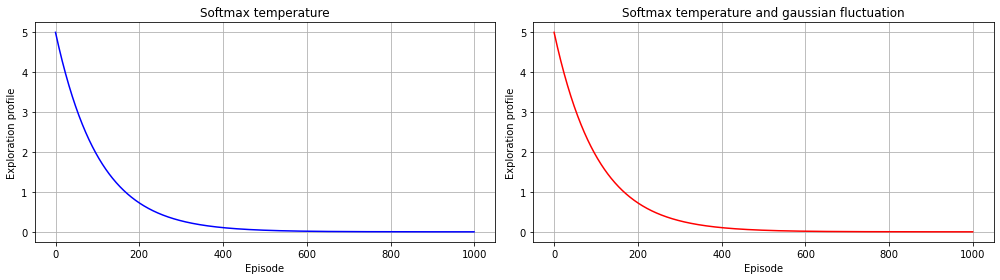

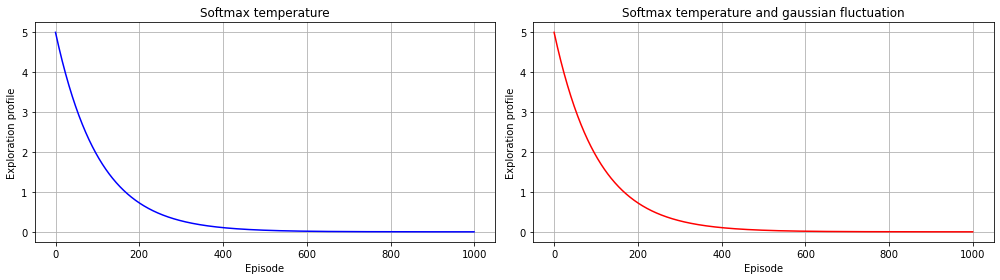

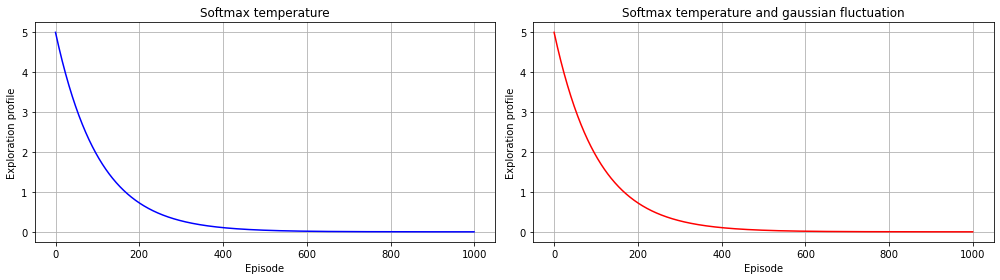

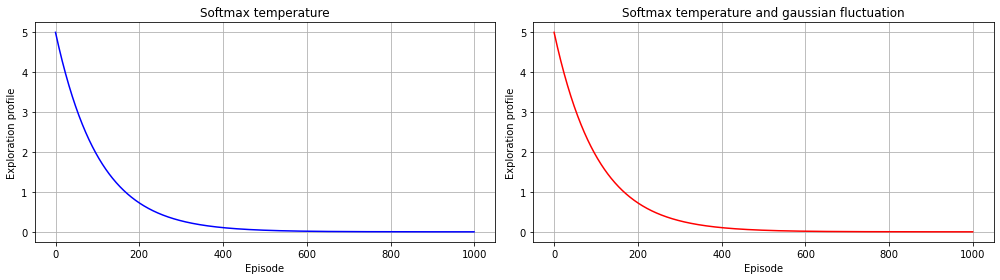

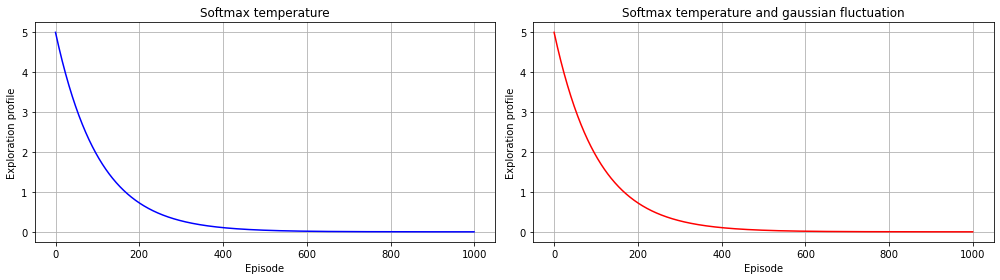

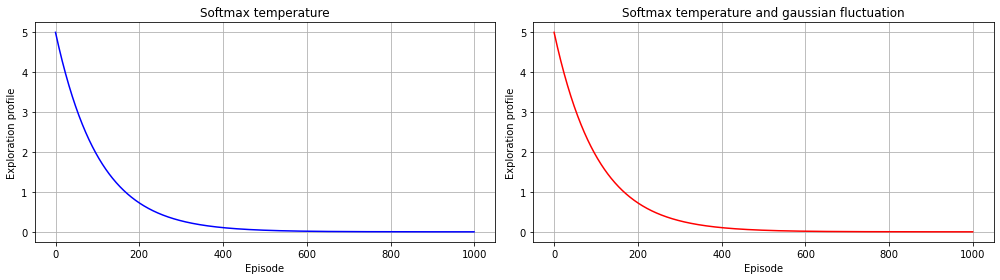

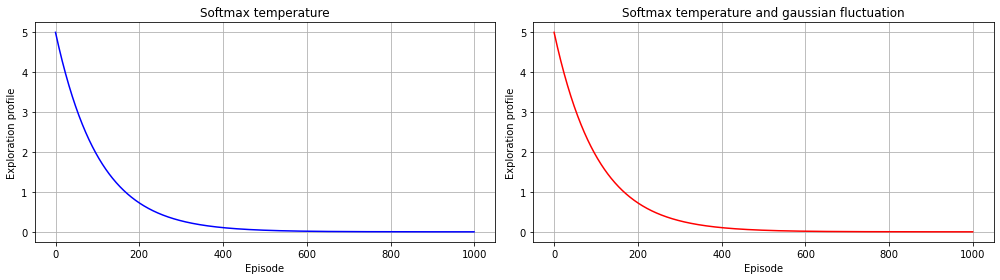

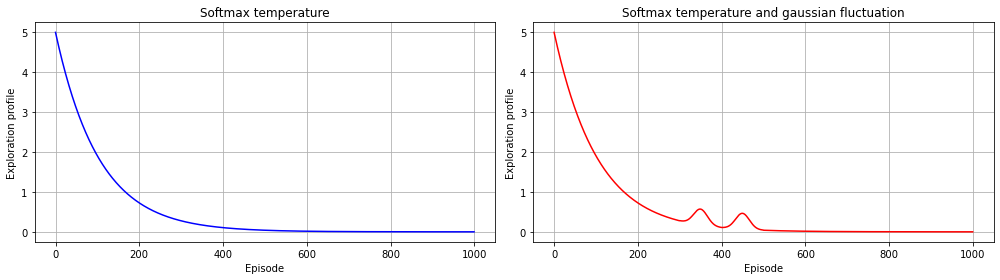

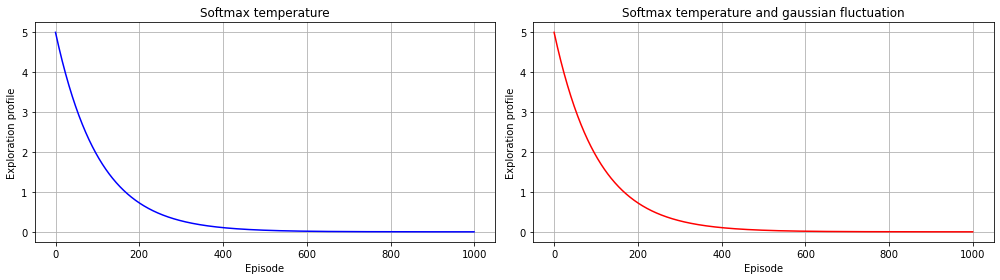

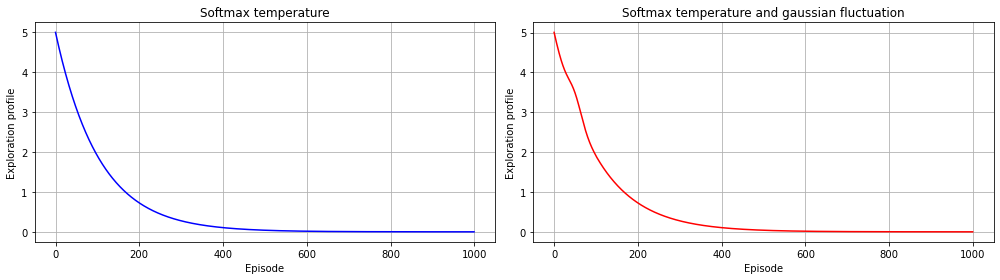

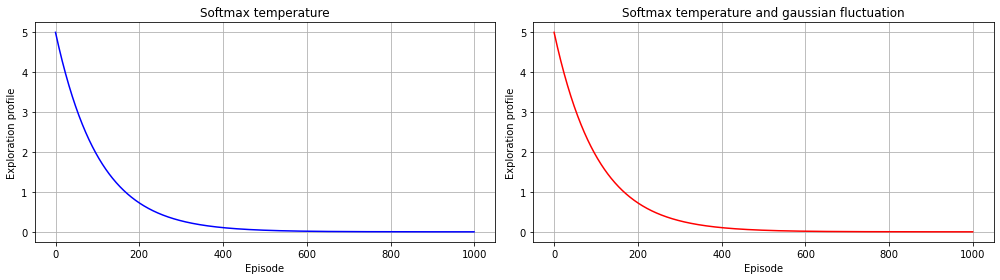

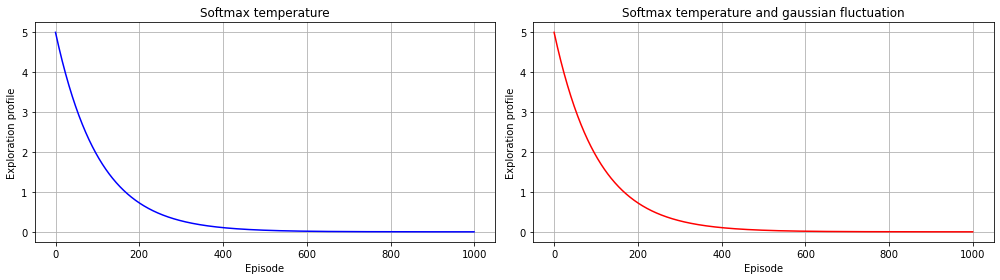

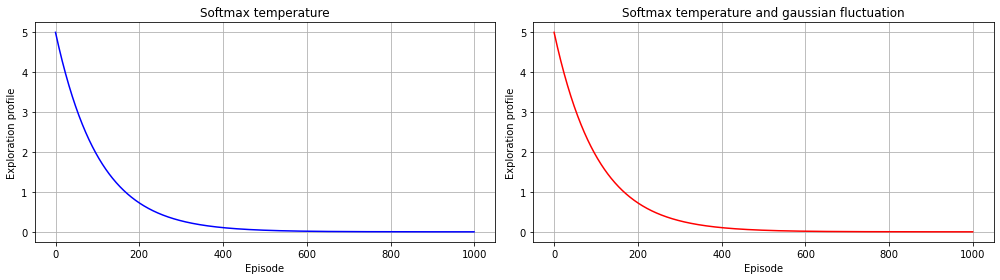

In [15]:
n_expl_profiles = 20
explorations = []

for _ in range(n_expl_profiles):
    sepr = softmax_exploration_profile(initial_value=5) # np.random.randint(3, 7)

    exploration = add_gauss_fluctuation(exploration_profile=sepr, plot=True)
    explorations.append(exploration)

In [16]:
hyperparams = {
    'gamma': np.linspace(0.9, 0.99, 10),
    'batch_size': [128], # [64, 128, 256]
    'learning_rate': np.logspace(-2, -1, 10),
    'target_net_update_steps': [5], # [10, 15]
    'replay_memory_capacity': [10000],
    'min_samples_for_training': [1000],
    'bad_state_penalty': [0]
}

def random_params_choice(hp):
    params = {}
    for i in hp.keys():
        params[i] = np.random.choice( hp[i] )
    return params

In [17]:
n_run = 30

all_params = []
all_train_scores = []
all_expl_profiles = []

run_search = False # Set to True to run the hyperparameters search

if run_search:
    for run in range(n_run):
        print(f'Running for task #{run+1}/{n_run} ...')

        # Set exploration profile
        exploration_profile = explorations[np.random.randint(0, n_expl_profiles)]

        # Choose parameters
        params = random_params_choice(hyperparams)

        # Initialization
        replay_mem, policy_net, target_net, optimizer, loss_fn = initialize(params)

        # Training
        policy_net, training_score = train_loop(policy_net, target_net, replay_mem, exploration_profile, params)

        all_params.append(params)
        all_train_scores.append(training_score)
        all_expl_profiles.append(exploration_profile)

In [18]:
save_dir = 'CartPole/'

if run_search:
    model = {}
    
    model['params'] = deepcopy(all_params)
    model['scores'] = deepcopy(all_train_scores)
    model['profis'] = deepcopy(all_expl_profiles)

    date_fmt = '%d_%m_%y-%Hh%Mm%S'
    now = datetime.now()
    date = now.strftime(date_fmt)
    os.makedirs(f'{save_dir}/', exist_ok=True)

    with open(f'{save_dir}{date}.result', 'wb') as file:
        file.write(pickle.dumps(model))

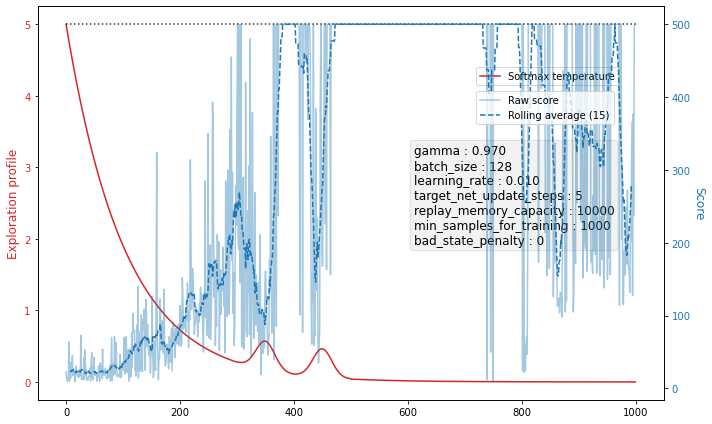

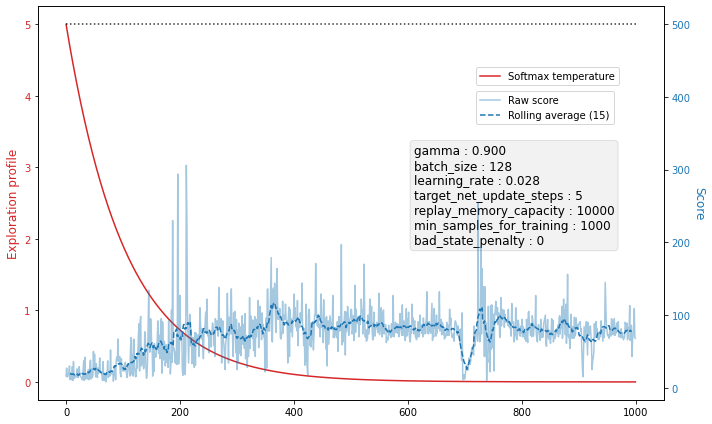

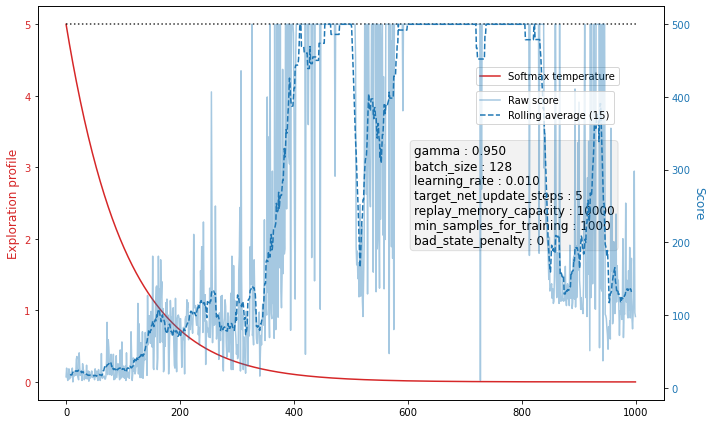

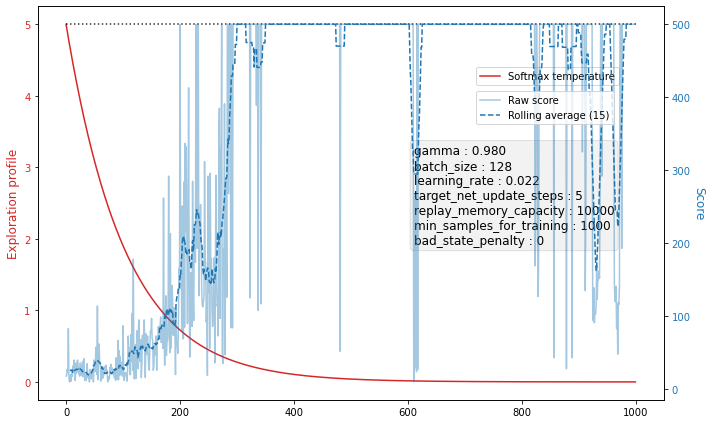

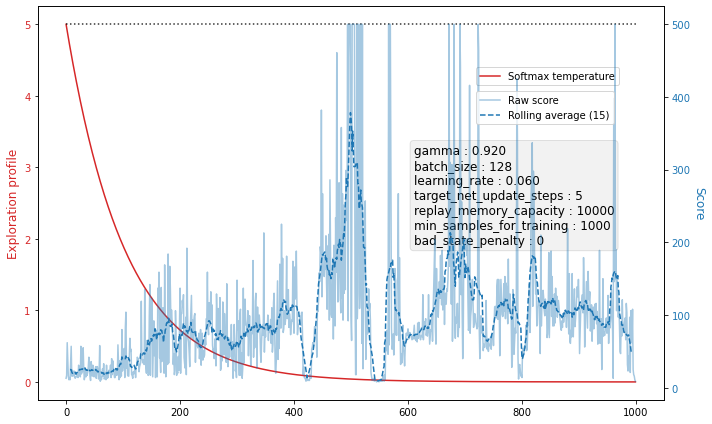

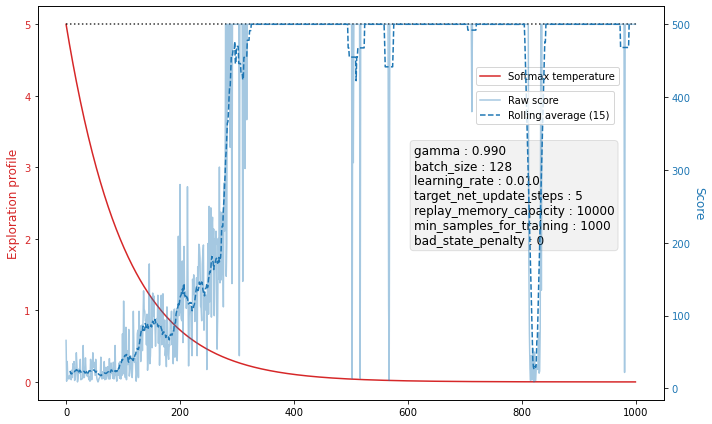

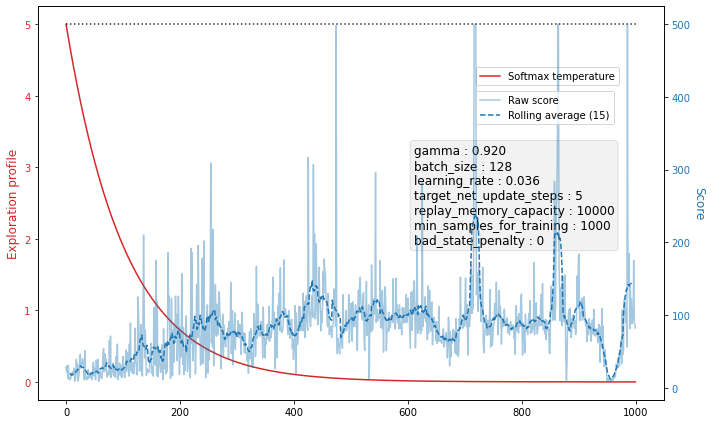

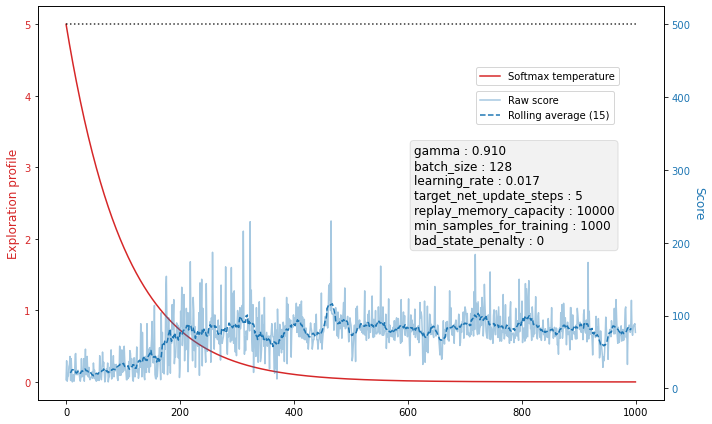

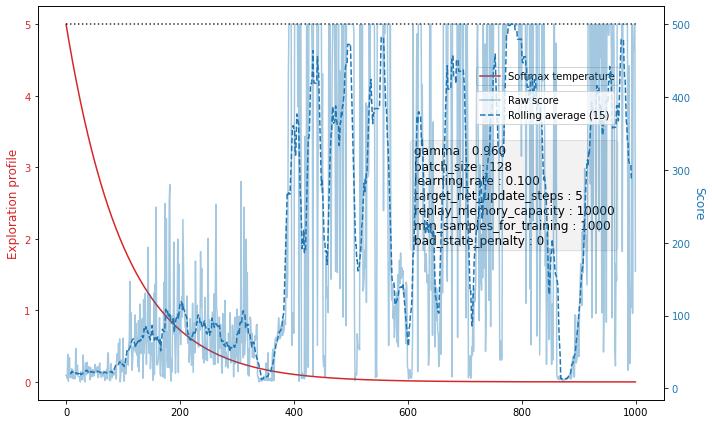

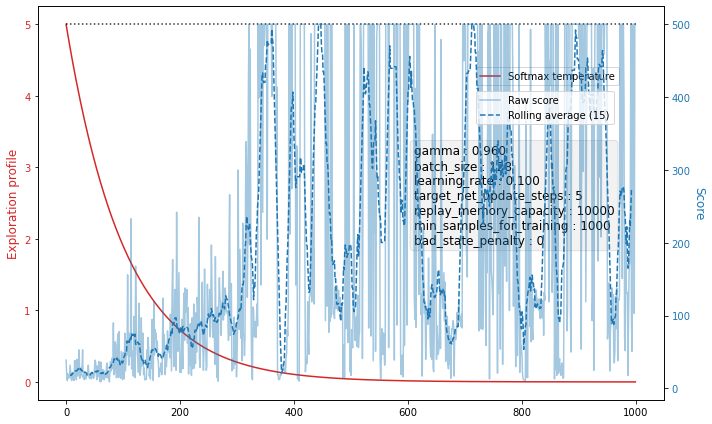

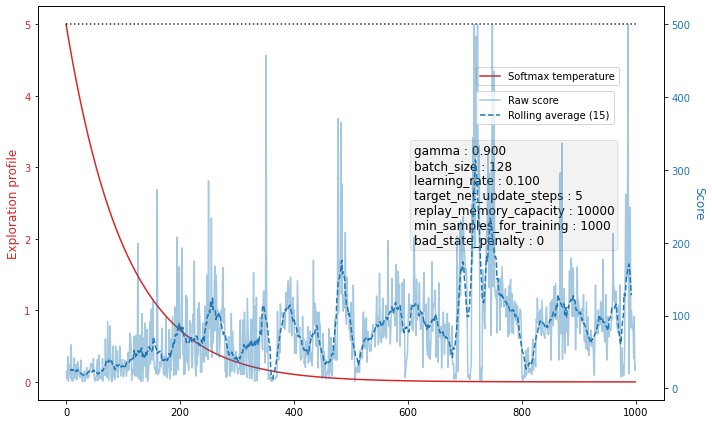

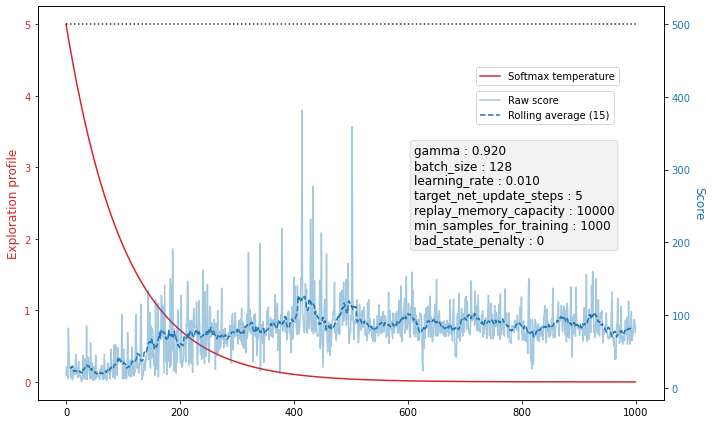

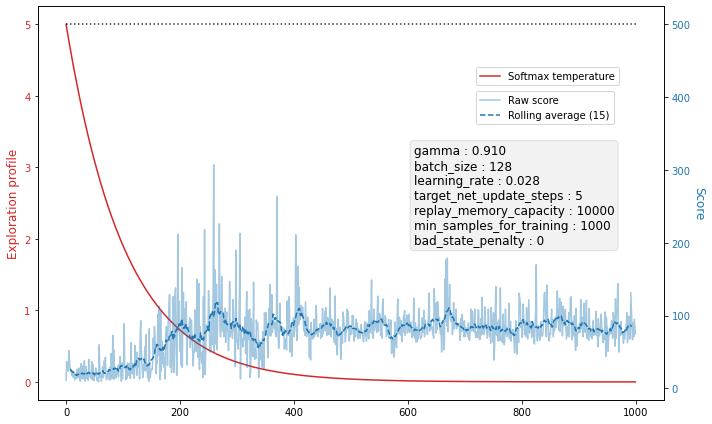

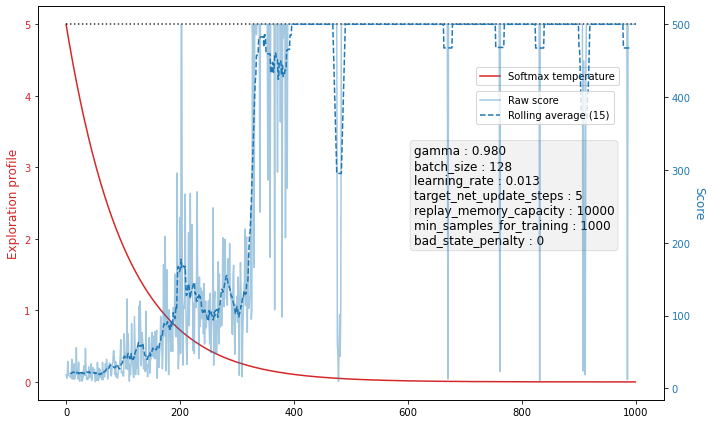

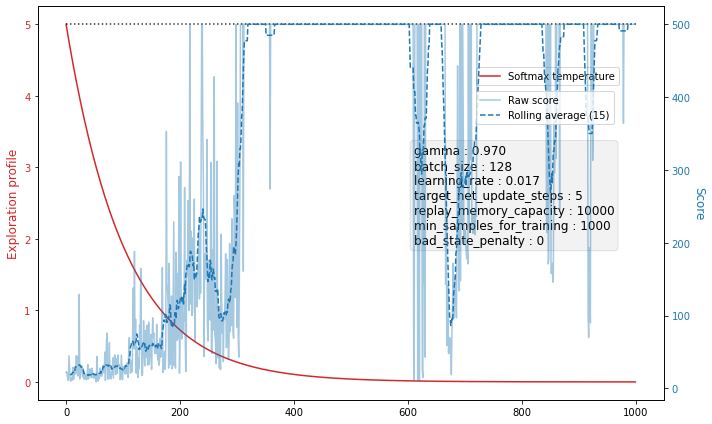

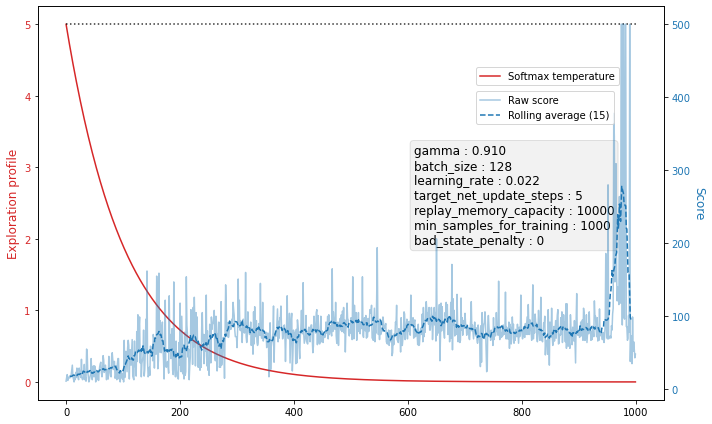

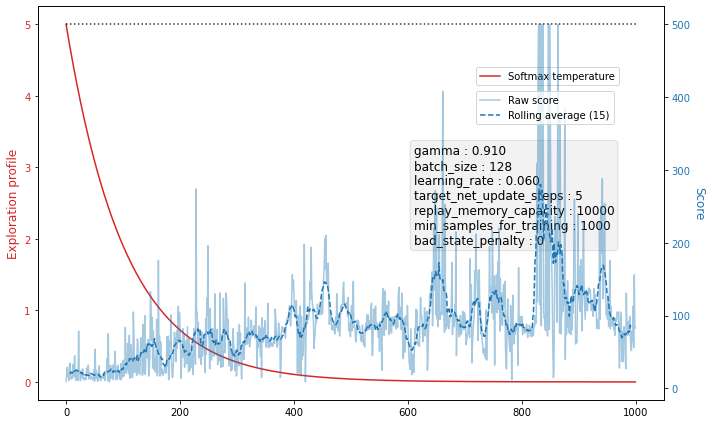

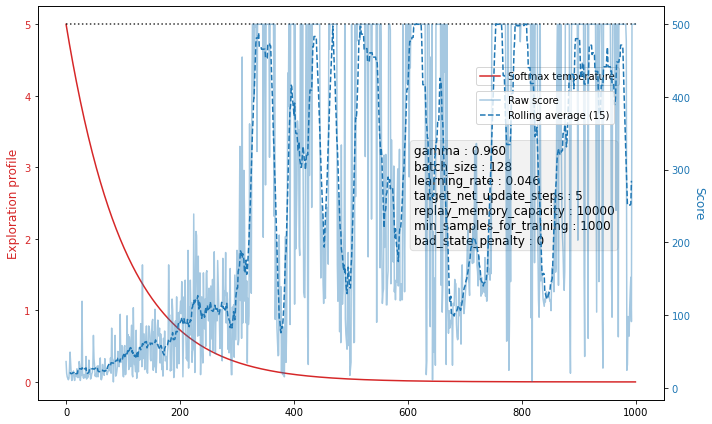

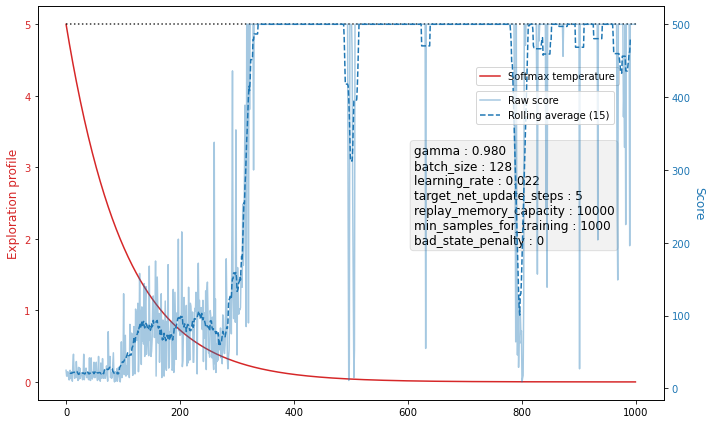

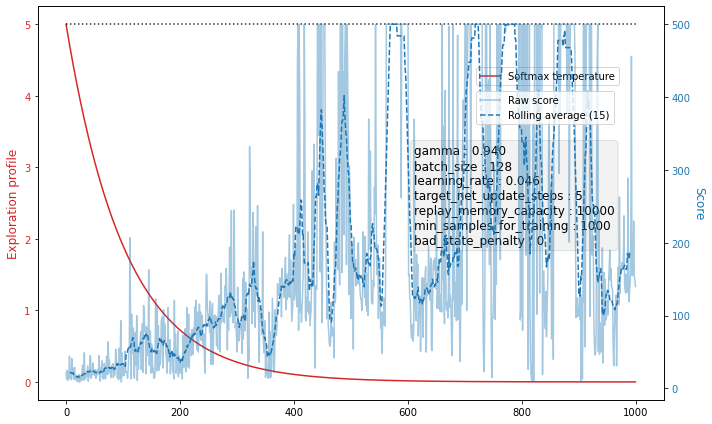

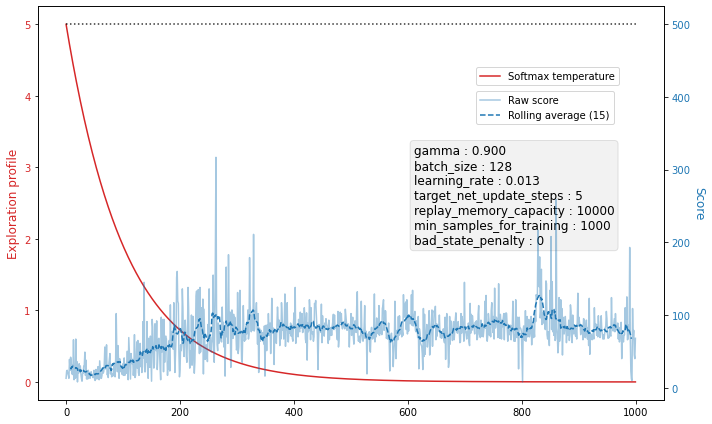

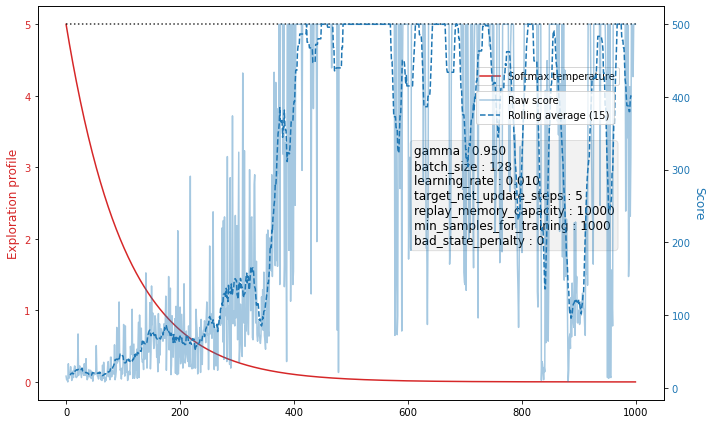

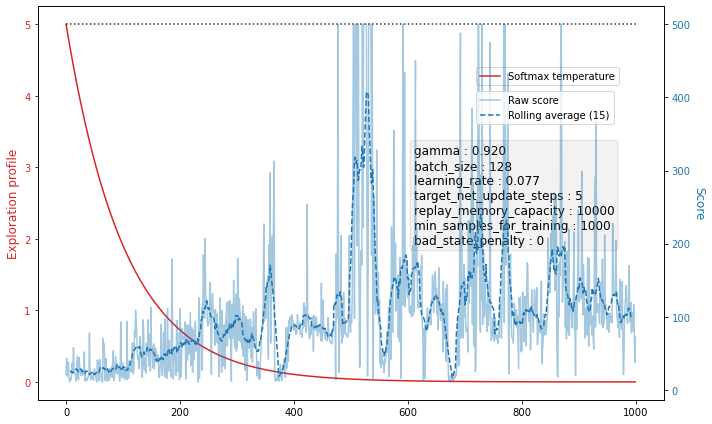

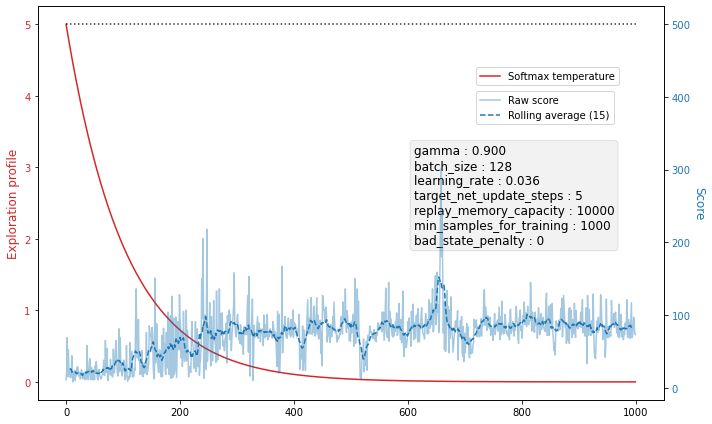

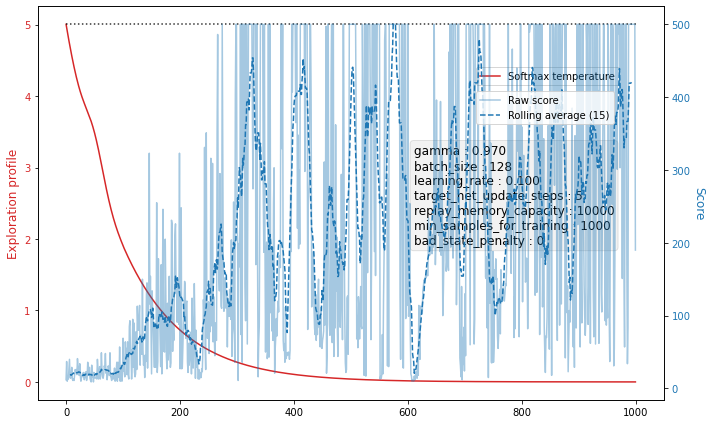

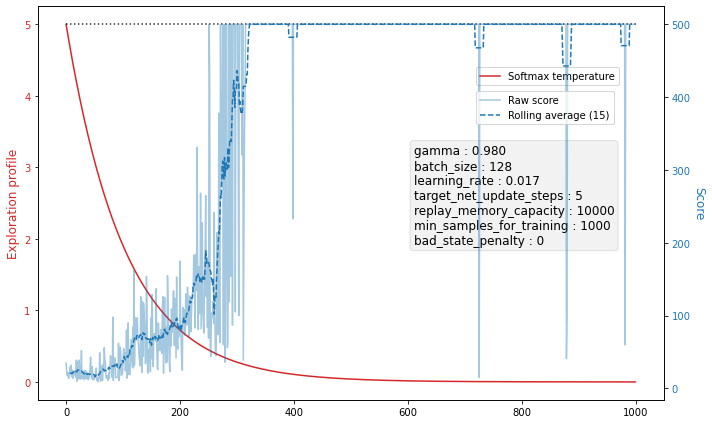

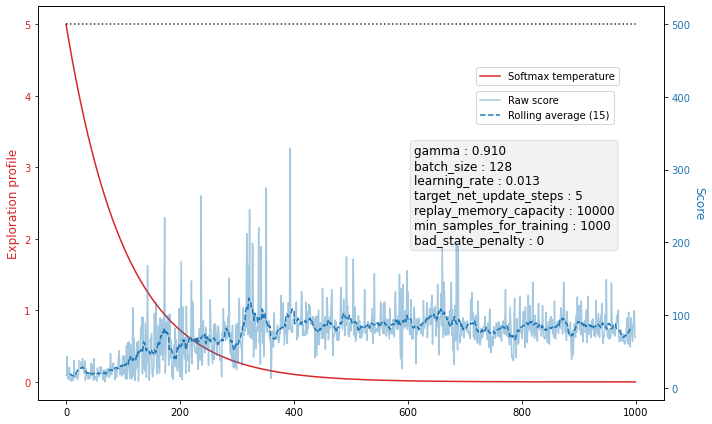

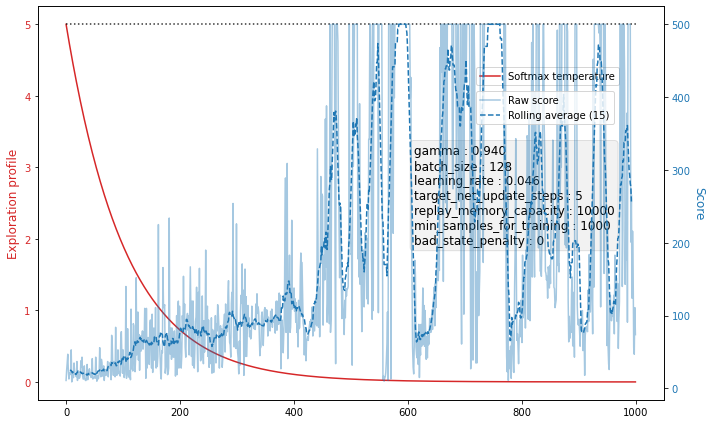

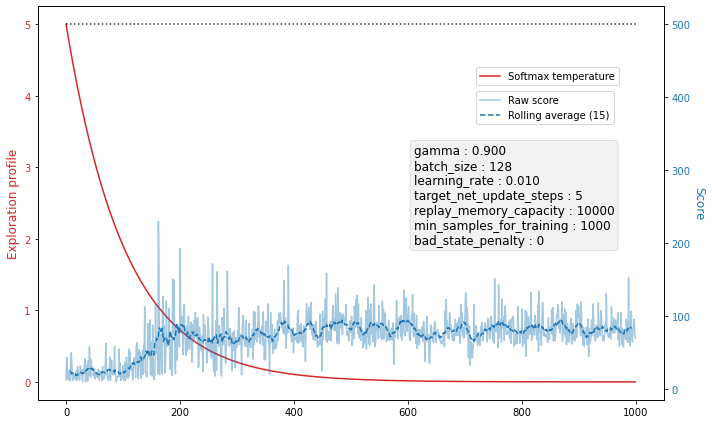

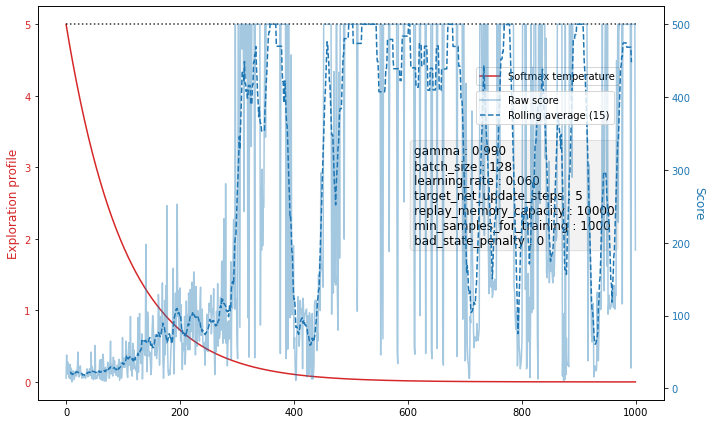

In [19]:
for file in glob.glob(f'{save_dir}/*.result'):
    with open(file, 'rb') as f:
        graph = pickle.loads(f.read())
        models = len(graph['params'])
        for m in range(models):
            ep = graph['profis'][m]
            ts = graph['scores'][m]
            ps = graph['params'][m]
            plot_score(ep, ts, ps)

The figures show clearly that when the hyperparameter set is optimal the score abruptly increases as soon as the temperature approaches zero: when the agent starts to choose the best action, the learning process takes a turn for the best. The exponential decay of the temperature is the profile that ultimately suits best this task. A bad choice can instead damage the learning so much that the agent is never able to solve the environment. Likewise, the gaussian fluctuations have a disruptive effect on the learning process: in correspondence with the gaussian peaks the score of the episodes drastically drops.

The best performing agents have a high learning rate, a high discount rate and a frequent update of the target network. This observations have led over repetitive trials to a progressive narrowing of the parameters' intervals: ultimately the final 30 trials have been carried out taking into account this considerations.

We re-train the network selecting the best hyperparameters, shown in the cell below.<br>
Lastly, the policy network was tested making the agent always choose the best action, in a greedy-like fashion. Under this conditions, the agent manages to always win the game, obtaining a perfect score of 500, proving the goodness of the strategy learned. We show some examples of winning runs below.

In [20]:
best_hp = {
    'gamma': 0.98,
    'batch_size': 128,
    'learning_rate': 0.016,
    'target_net_update_steps': 5,
    'replay_memory_capacity': 10000,
    'bad_state_penalty': 0,
    'min_samples_for_training': 1000
}

In [21]:
# Set exploration profile
exploration_profile = softmax_exploration_profile()

# Choose parameters
params = best_hp

# Initialization
replay_mem, policy_net, target_net, optimizer, loss_fn = initialize(params)

# Training
policy_net, training_score = train_loop(policy_net, target_net, replay_mem, exploration_profile, params)

  0%|          | 0/1000 [00:00<?, ?it/s]

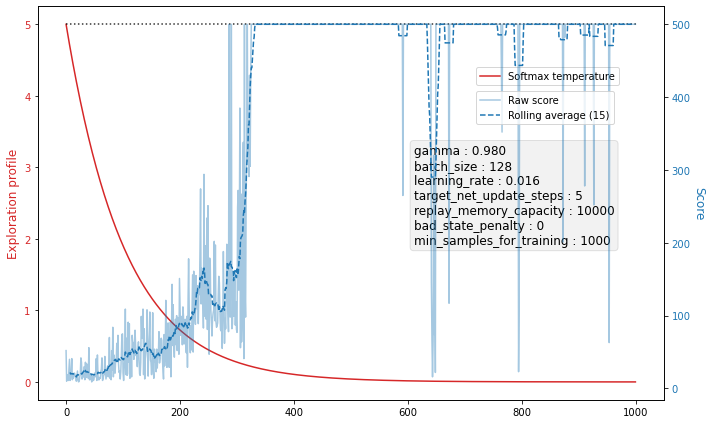

In [22]:
plot_score(exploration_profile, training_score, best_hp)

In [23]:
# Initialize the Gym environment
env = gym.make('CartPole-v1')
env.seed(seed)

env = wrap_env(env, save_dir='./CartPole_videos', video_callable=lambda episode_id: True) # Save a video every episode

# Total of 10 episodes
for num_episode in tqdm(range(10)): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    
    while not done:
        with torch.no_grad():
            action = int(policy_net(torch.tensor(state, dtype=torch.float32)).argmax())

        # Apply the action and get the next state, the reward and a flag 'done' that is True if the game is ended
        next_state, reward, done, info = env.step(action)
        # Visually render the environment
        env.render()
        # Update the final score (+1 for each step)
        score += reward 
        # Set the current state for the next iteration
        state = next_state
    
    # Print the final score
    print(f'EPISODE {num_episode + 1} - FINAL SCORE: {score}') 
env.close() 

  0%|          | 0/10 [00:00<?, ?it/s]

EPISODE 1 - FINAL SCORE: 500.0
EPISODE 2 - FINAL SCORE: 500.0
EPISODE 3 - FINAL SCORE: 500.0
EPISODE 4 - FINAL SCORE: 500.0
EPISODE 5 - FINAL SCORE: 500.0
EPISODE 6 - FINAL SCORE: 500.0
EPISODE 7 - FINAL SCORE: 500.0
EPISODE 8 - FINAL SCORE: 500.0
EPISODE 9 - FINAL SCORE: 500.0
EPISODE 10 - FINAL SCORE: 500.0


In [24]:
show_videos(save_dir='./CartPole_videos')


SHOWING VIDEO ./CartPole_videos/openaigym.video.0.3251.video000000.mp4



SHOWING VIDEO ./CartPole_videos/openaigym.video.0.3251.video000001.mp4



SHOWING VIDEO ./CartPole_videos/openaigym.video.0.3251.video000002.mp4



SHOWING VIDEO ./CartPole_videos/openaigym.video.0.3251.video000003.mp4



SHOWING VIDEO ./CartPole_videos/openaigym.video.0.3251.video000004.mp4



SHOWING VIDEO ./CartPole_videos/openaigym.video.0.3251.video000005.mp4



SHOWING VIDEO ./CartPole_videos/openaigym.video.0.3251.video000006.mp4



SHOWING VIDEO ./CartPole_videos/openaigym.video.0.3251.video000007.mp4



SHOWING VIDEO ./CartPole_videos/openaigym.video.0.3251.video000008.mp4



SHOWING VIDEO ./CartPole_videos/openaigym.video.0.3251.video000009.mp4


<a id='6'></a>
[Index](#index)
### 6. MountainCar

In this section the same DQN model presented for the `CartPole` is used to solve `gym`'s `MountainCar` environment. In this setting, according to the relative [documentation](https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py),

> A car is on a one-dimensional track, positioned between two "mountains". The goal is to drive up the mountain on the right; however, the car's engine is not strong enough to scale the mountain in a single pass. Therefore, the only way to succeed is to drive back and forth to build up momentum.

Observation space is a 2-dim vector, where the 1st element represents the "car position" and the 2nd element represents the "car velocity". There are 3 discrete deterministic actions:
- **0**: Accelerate to the left;
- **1**: Don't accelerate;
- **2**: Accelerate to the right.

Denoting with $x_C$ and $v_C$ the car's position and velocity respectively, it holds $x_C\in[-1.2,0.6]$, $v_C\in[-0.07,0.07]$. The agent receives a 0 reward if it reaches a position $x_C>0.5$ (which corresponds to the flag on top of the mountain) or a -1 for every step it does not. An episode ends when the car position is $x_C>0.5$ or when 200 steps are taken.

In [25]:
env = gym.make('MountainCar-v0')
env.seed(seed)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f'State space size: {state_space_dim}')
print(f'Action space size: {action_space_dim}')

State space size: 2
Action space size: 3


The functions applied are the same used for the `CartPole` problem: the DQN class is built to be flexible to the difference in the dimension of the action space (3, and not 2) and of the observation space (2, not 4) and it was therefore chosen as model for the policy/target networks. The exploration profile is an exponential one, starting from $\tau=1$. The training parameters are set based on what has been observed before, after a trial and error procedure.

To assure convergence and speed up significantly the learning process, the reward was tweaked in order to encourage actions that actually help the car in building up momentum. In detail, the reward is increased by

- +1, if the car moves to the right and accelerates in the same direction;
- +1, if the car moves to the left and accelerates in the same direction;
- +1, if the car reaches a position $x_C>0.5$, i.e. it solves the environment.

In this way, the agent will receive a negative reward of −1 both for inconclusive moves and if its position is not the winning one, 0 if it chooses the right move, +1 if it wins the game.

With this premises, in this framework the agent trained manages to perfectly solve the environment after less than 50
episodes: in the exploration profile/score vs. episode plot, the converging behaviour of the learning process is evident. We plot also the maximum position reached by the car: after less than 25 episodes the car reaches for the first time the top of the mountain.

Lastly, we repeat what was shown for the `CartPole`, testing the policy network by making the agent always choose the best action. The score printed in this case does not take into account our modification to the reward. Nevertheless, we consider the environment successfully solved, as the videos attached show. Indeed, after the training, the agent learned to climb the mountain with just 2−3 back and forth oscillations.

In [26]:
# Define an example network
net = DQN(state_space_dim, action_space_dim)
print(net)

DQN(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=3, bias=True)
  )
)


set reward to +1 (and not 0 if the car wins the game)

In [27]:
def train_loop(policy_net, target_net, replay_mem, exploration_profile, params, verbose=False):
    # Initialize the Gym environment
    env = gym.make('MountainCar-v0')
    env.seed(seed)
    
    # Initialise output list containing all the scores and the car positions
    max_positions = []
    training_score = []

    for episode_num, tau in enumerate(tqdm(exploration_profile)):

        # Reset the environment and get the initial state
        state = env.reset()
        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done = False # True if the game has ended
        max_position = state[0]

        # Go on until the ending conditions are met: 
        # x = 0.5 is reached or episode lasts more than 200 iterations
        while not done:

            # Choose the action following the policy
            action, q_values = choose_action_softmax(policy_net, state, temperature=tau)

            # Apply the action and get the next state, the reward and a flag \'done\' that is True if the game is ended
            next_state, reward, done, info = env.step(action)
            
            # Tweak reward base on the action
            if next_state[0] - state[0] > 0 and action == 2: reward += 1
            if next_state[0] - state[0] < 0 and action == 0: reward += 1
            if next_state[0] >= 0.5: reward += 1
                
            score += reward

            # Tracking maximum reached distance
            if next_state[0] > max_position:
                max_position = next_state[0]
                
            # Apply penalty for bad state
            if done: 
                reward += params['bad_state_penalty']
                next_state = None

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # Update the network:
            # we enable the training only if we have enough samples in the replay
            # memory, otherwise the training will use the same samples too often
            if len(replay_mem) > params['min_samples_for_training']:
                update_step(policy_net, target_net, replay_mem, params, optimizer, loss_fn)

            # Visually render the environment (disable to speed up the training)
            env.render()

            # Set the current state for the next iteration
            state = next_state

        # Update the target network every target_net_update_steps episodes
        if episode_num % params['target_net_update_steps'] == 0:
            if verbose:
                print('Updating target network...')
            # Copy the weights of the policy network to the target network
            target_net.load_state_dict(policy_net.state_dict())

        # Print final score
        if verbose:
            print(f'EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}')
            
        max_positions.append(max_position)
        training_score.append(score)
        
    env.close()
    
    return policy_net, max_positions, training_score

In [28]:
car_hp = {
    'gamma': 0.97,
    'batch_size': 32,
    'learning_rate': 0.013,
    'target_net_update_steps': 5,
    'replay_memory_capacity': 10000,
    'bad_state_penalty': 0,
    'min_samples_for_training': 1000
}

In [29]:
# Set exploration profile
exploration_profile = softmax_exploration_profile(num_iterations=200, initial_value=1)

# Choose parameters
params = car_hp

# Initialization
replay_mem, policy_net, target_net, optimizer, loss_fn =\
initialize(params, action_space_dim=action_space_dim, state_space_dim=state_space_dim)

# Training
policy_net, positions, training_score = train_loop(policy_net, target_net, replay_mem, exploration_profile, params)

  0%|          | 0/200 [00:00<?, ?it/s]

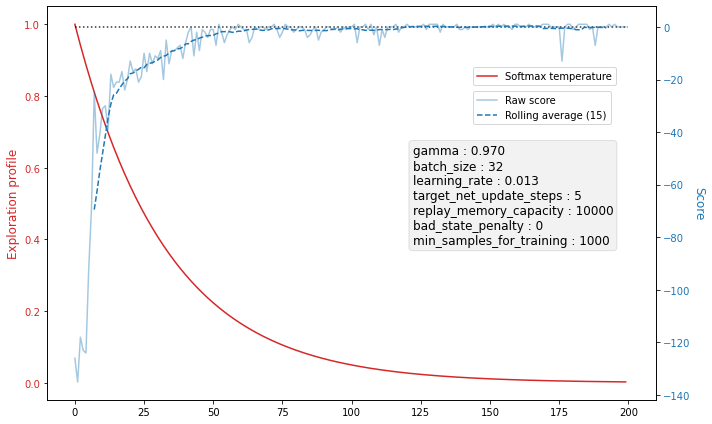

In [30]:
plot_score(exploration_profile, training_score, car_hp, gym='car')

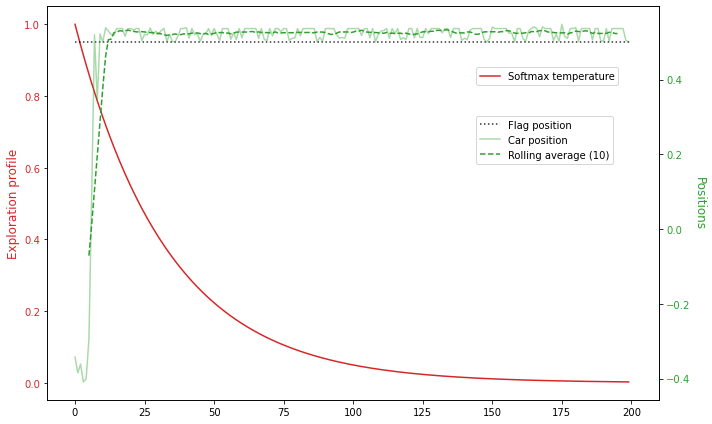

In [31]:
xmin = 0; xmax = 200
y = .5

fig, ax = plt.subplots(figsize=(10,6))

color = 'tab:red'
ax.set_ylabel('Exploration profile', size=12, c=color)
ax.plot(exploration_profile, c=color, label='Softmax temperature')
ax.tick_params(axis='y', labelcolor=color)

ax2 = ax.twinx()

color = 'tab:green'   
ax2.set_xlabel('Episode')
ax2.set_ylabel('Positions', c=color, size=12, rotation=270, labelpad=15)
ax2.hlines(y, xmin, xmax, colors='black', linestyles='dotted', alpha=.8, label='Flag position')
ax2.plot(positions, c=color, alpha=.4, label='Car position')
winw = 10
ax2.plot(*rolling_average(positions, winw), '--', color=color, label=f'Rolling average ({winw})')
ax2.tick_params(axis='y', labelcolor=color)

ax2.legend(loc=(0.7, 0.6))
ax.legend(loc=(0.7, 0.8))

fig.tight_layout()
plt.show()

In [32]:
# Initialize the Gym environment
env = gym.make('MountainCar-v0')
env.seed(seed)

env = wrap_env(env, save_dir='./MountainCar_videos', video_callable=lambda episode_id: True) # Save a video every episode

# Total of 10 episodes
for num_episode in tqdm(range(10)): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    steps = 0
    
    while not done:
        with torch.no_grad():
            action = int(policy_net(torch.tensor(state, dtype=torch.float32)).argmax())

        # Apply the action and get the next state, the reward and a flag 'done' that is True if the game is ended
        next_state, reward, done, info = env.step(action)
        # Visually render the environment
        env.render()
        # Update the final score (+1 for each step)
        score += reward 
        # Set the current state for the next iteration
        state = next_state
        steps += 1
    
    # Print the final score
    print(f'EPISODE {num_episode + 1} - # STEPS: {steps}') 
env.close() 

  0%|          | 0/10 [00:00<?, ?it/s]

EPISODE 1 - # STEPS: 112
EPISODE 2 - # STEPS: 84
EPISODE 3 - # STEPS: 102
EPISODE 4 - # STEPS: 114
EPISODE 5 - # STEPS: 112
EPISODE 6 - # STEPS: 97
EPISODE 7 - # STEPS: 117
EPISODE 8 - # STEPS: 97
EPISODE 9 - # STEPS: 112
EPISODE 10 - # STEPS: 118


In [33]:
show_videos(save_dir='./MountainCar_videos')


SHOWING VIDEO ./MountainCar_videos/openaigym.video.1.3251.video000000.mp4



SHOWING VIDEO ./MountainCar_videos/openaigym.video.1.3251.video000001.mp4



SHOWING VIDEO ./MountainCar_videos/openaigym.video.1.3251.video000002.mp4



SHOWING VIDEO ./MountainCar_videos/openaigym.video.1.3251.video000003.mp4



SHOWING VIDEO ./MountainCar_videos/openaigym.video.1.3251.video000004.mp4



SHOWING VIDEO ./MountainCar_videos/openaigym.video.1.3251.video000005.mp4



SHOWING VIDEO ./MountainCar_videos/openaigym.video.1.3251.video000006.mp4



SHOWING VIDEO ./MountainCar_videos/openaigym.video.1.3251.video000007.mp4



SHOWING VIDEO ./MountainCar_videos/openaigym.video.1.3251.video000008.mp4



SHOWING VIDEO ./MountainCar_videos/openaigym.video.1.3251.video000009.mp4


<a id='7'></a>
[Index](#index)
### 7. Conclusion

In this work we applied DQNs to solve two different tasks from the `gym` environment. The simulations were run with different sets of training parameters and tested over different configurations of exploration profiles. In both cases the agent successfully learned to solve the game in a number of steps noticeably smaller than the simulation time window.